In [9]:
%env CUDA_VISIBLE_DEVICES=1 # set device number

import torch
import torch.nn.functional as F
from torchvision.transforms import ToPILImage
from torchvision.io import read_image
from pytorch_lightning import seed_everything
from diffusers import DDIMScheduler

from MasaCtrl.diffuser_utils import MasaCtrlPipeline
from MasaCtrl.masactrl_utils import regiter_attention_editor_diffusers
from MasaCtrl.masactrl import MutualSelfAttentionControl

env: CUDA_VISIBLE_DEVICES=1 # set device number


In [10]:
def load_image(image_path, device):
    image = read_image(image_path)
    image = image[:3].unsqueeze_(0).float() / 127.5 - 1.  # [-1, 1]
    image = F.interpolate(image, (512, 512))
    image = image.to(device)
    return image

In [11]:
# load stable diffusion and scheduler
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
model_path = "CompVis/stable-diffusion-v1-4"
scheduler = DDIMScheduler(beta_start=0.00085, beta_end=0.012, beta_schedule="scaled_linear", clip_sample=False, set_alpha_to_one=False)
model = MasaCtrlPipeline.from_pretrained(model_path, scheduler=scheduler).to(device)

seed = 42
seed_everything(seed)

`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["id2label"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["bos_token_id"]` will be overriden.
`text_config_dict` is provided which will be used to initialize `CLIPTextConfig`. The value `text_config["eos_token_id"]` will be overriden.
Global seed set to 42


42

## Viewpoint Alternation

In [12]:
# load image
img_path = 'images/img6.jpg'
img = load_image(img_path, device)

# set source and target prompt
src_prompt = "a woman with her eyes closed"
trg_prompt = "a woman with her eyes closed, frontal view"
prompts = [src_prompt, trg_prompt]

# invert the source image
start_code, latents_list = model.invert(img,
                                        src_prompt,
                                        guidance_scale=1,
                                        num_inference_steps=50,
                                        return_intermediates=True)
start_code = start_code.expand(len(prompts), -1, -1, -1)

input text embeddings : torch.Size([1, 77, 768])
latents shape:  torch.Size([1, 4, 64, 64])
Valid timesteps:  tensor([  1,  21,  41,  61,  81, 101, 121, 141, 161, 181, 201, 221, 241, 261,
        281, 301, 321, 341, 361, 381, 401, 421, 441, 461, 481, 501, 521, 541,
        561, 581, 601, 621, 641, 661, 681, 701, 721, 741, 761, 781, 801, 821,
        841, 861, 881, 901, 921, 941, 961, 981])


DDIM Inversion:   0%|          | 0/50 [00:00<?, ?it/s]

DDIM Inversion: 100%|██████████| 50/50 [00:03<00:00, 13.08it/s]


step_idx:  [4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49]
layer_idx:  [10, 11, 12, 13, 14, 15]
input text embeddings : torch.Size([2, 77, 768])
latents shape:  torch.Size([2, 4, 64, 64])


DDIM Sampler:   0%|          | 0/50 [00:00<?, ?it/s]

DDIM Sampler: 100%|██████████| 50/50 [00:25<00:00,  1.94it/s]


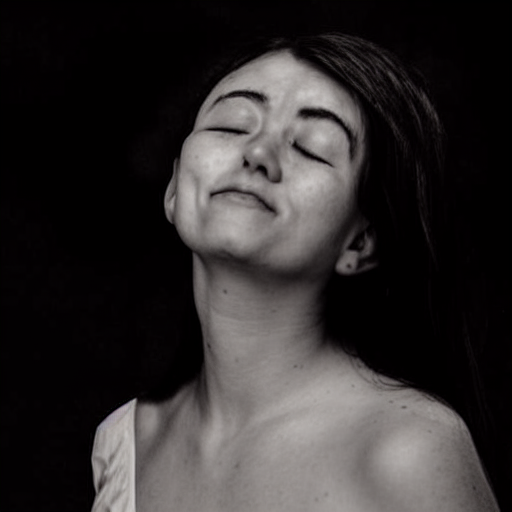

In [13]:
# inference the synthesized image with MasaCtrl
STEP = 4
LAYER = 10

# hijack the attention module
editor = MutualSelfAttentionControl(STEP, LAYER)
regiter_attention_editor_diffusers(model, editor)

# set NMG parameters
grad_scale = 5000 # gradient scale
guidance_noise_map = 10 # NMG scale
guidance_text = 10 # CFG scale

# inference the synthesized image
image_masactrl = model(prompts,
                       latents=start_code,
                       guidance_scale=guidance_text,
                       ref_intermediate_latents=latents_list,
                       grad_scale=grad_scale,
                       guidance_noise_map=guidance_noise_map)
ToPILImage()(image_masactrl[1])

## Pose Modification

In [14]:
# load image
img_path = 'images/img7.jpg'
img = load_image(img_path, device)

# set source and target prompt
src_prompt = "a small kitten standing on top of a table"
trg_prompt = "a small kitten sitting on top of a table"
prompts = [src_prompt, trg_prompt]

# invert the source image
start_code, latents_list = model.invert(img,
                                        src_prompt,
                                        guidance_scale=1,
                                        num_inference_steps=50,
                                        return_intermediates=True)
start_code = start_code.expand(len(prompts), -1, -1, -1)

input text embeddings : torch.Size([1, 77, 768])
latents shape:  torch.Size([1, 4, 64, 64])
Valid timesteps:  tensor([  1,  21,  41,  61,  81, 101, 121, 141, 161, 181, 201, 221, 241, 261,
        281, 301, 321, 341, 361, 381, 401, 421, 441, 461, 481, 501, 521, 541,
        561, 581, 601, 621, 641, 661, 681, 701, 721, 741, 761, 781, 801, 821,
        841, 861, 881, 901, 921, 941, 961, 981])


DDIM Inversion: 100%|██████████| 50/50 [00:03<00:00, 16.18it/s]


step_idx:  [4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49]
layer_idx:  [10, 11, 12, 13, 14, 15]
input text embeddings : torch.Size([2, 77, 768])
latents shape:  torch.Size([2, 4, 64, 64])


DDIM Sampler: 100%|██████████| 50/50 [00:18<00:00,  2.71it/s]


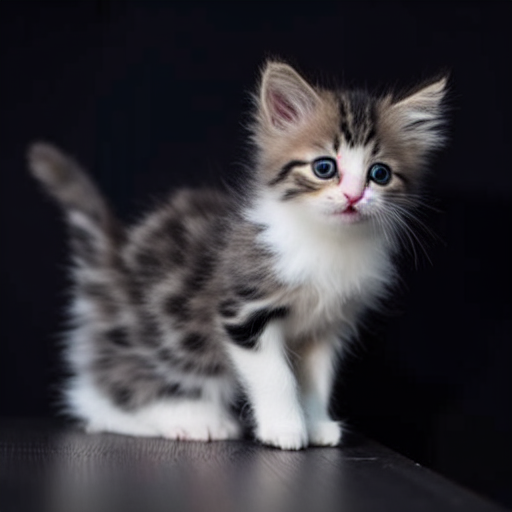

In [15]:
# inference the synthesized image with MasaCtrl
STEP = 4
LAYER = 10

# hijack the attention module
editor = MutualSelfAttentionControl(STEP, LAYER)
regiter_attention_editor_diffusers(model, editor)

# set NMG parameters
grad_scale = 5000 # gradient scale
guidance_noise_map = 10 # NMG scale
guidance_text = 10 # CFG scale

# inference the synthesized image
image_masactrl = model(prompts,
                       latents=start_code,
                       guidance_scale=guidance_text,
                       ref_intermediate_latents=latents_list,
                       grad_scale=grad_scale,
                       guidance_noise_map=guidance_noise_map)
ToPILImage()(image_masactrl[1])